In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import oh_to_12pluslog, mu, get_velocity_profile, get_velocity_evolution, boxcarsmoothtrend
from src.simulations.models.utils import sinusoid, tilted_sinusoid
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


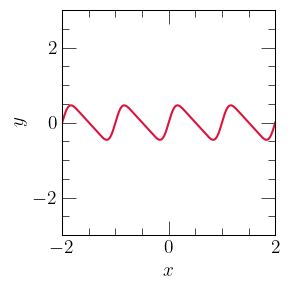

In [11]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xlim([-2, 2])
ax.set_ylim([-3, 3])

ts = tilted_sinusoid(skewness = 5, amplitude = 0.25)
# ts = sinusoid()
xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
yvals = [ts(x) for x in xvals]
ax.plot(xvals, yvals, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

In [53]:
output = vice.output("../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p1-0p4Gyr-skew5")
# output = vice.output("../outputs/angular-momentum-dilution/betaphiin0p7")

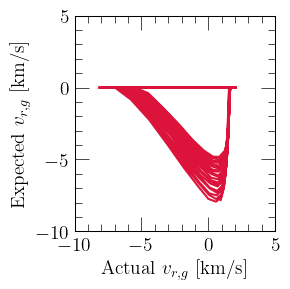

In [54]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Actual $v_{r,g}$ [km/s]")
ax.set_ylabel(r"Expected $v_{r,g}$ [km/s]")
ax.set_xlim([-10, 5])
# ax.set_xlim([-1, 0])
ax.set_ylim(ax.get_xlim())
# ax.set_xscale("log")
# ax.set_yscale("log")

def plot_comparison(output, start = 8, radius = 8, zone_width = 0.1, betaphiin = 0.7, **kwargs):
    zone = output.zones["zone%d" % (int(radius / zone_width))]
    diff = [abs(_ - start) for _ in zone.history["lookback"]]
    idx = diff.index(min(diff))
    expected = []
    lookback = zone.history["lookback"][idx:]
    for i in range(idx, len(zone.history["time"])):
        expected.append(-radius * 1.e9 * zone.history["ifr"][i] / zone.history["mgas"][i] * (1 - betaphiin))
    lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
    # print(list(zip(lookback, vgas)))
    diff = [abs(_ - start) for _ in lookback]
    idx = diff.index(min(diff))
    vgas = vgas[idx:]
    # print(vgas)
    # print(expected)
    ax.plot(vgas, expected, **kwargs)

plot_comparison(output, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

In [20]:
outputs = [
    # "../outputs/angular-momentum-dilution/betaphiin0p7-sfroscil-amplitude0p5-period0p2",
    "../outputs/constant/vgas-0p5",
    # "../outputs/oscillatory/mean-0p5-amplitude1-period0p2",
    # "../outputs/oscillatory/mean-0p5-amplitude3-period0p2",
    # "../outputs/oscillatory/mean-0p5-amplitude10-period0p2",
    # "../outputs/oscillatory/mean-0p5-amplitude10-period0p2-sfroscil-amplitude0p5-period0p2"
    # "../outputs/potential-well-deepening/gamma0p2-oscil-0p8-0p2Gyr",
    # "../outputs/potential-well-deepening/gamma0p2-oscil-0p6-0p2Gyr",
    # "../outputs/potential-well-deepening/gamma0p2-oscil-0p4-0p2Gyr"
    # "../outputs/constant/vgas-0p5",
    # "../outputs/oscillatory/mean-0p5-amplitude10-period0p2",
    # "../outputs/potential-well-deepening/gamma0p2-oscil-0p1-0p2Gyr-skew5",
    # "../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p1-0p2Gyr-skew5"
    "../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p1-0p2Gyr-skew5",
    "../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p25-0p2Gyr-skew5",
    "../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p1-0p4Gyr-skew5"
    # "../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p25-0p2Gyr-skew10",
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

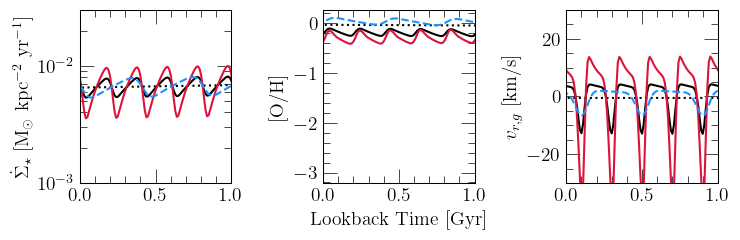

In [21]:
COLORS = ["black", "black", "crimson", "dodgerblue"]
LINESTYLES = [":", "-", "-", "--"]
RADIUS = 8

fig = plt.figure(figsize = (7.5, 2.5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set_yscale("log")
# ax2.set_yscale("log")
ax2.set_xlabel(r"Lookback Time [Gyr]")
ax1.set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax2.set_ylabel(r"[O/H]")
# ax2.set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax3.set_ylabel(r"$v_{r,g}$ [km/s]")
for ax in [ax1, ax2, ax3]:
    ax.set_xlim([0, 1])
ax1.set_ylim([1.e-3, 0.03])
# ax2.set_ylim([-0.1, 0.1])
ax3.set_ylim([-30, 30])

def plot_evolution(ax_sfr, ax_oh, ax_v, output, radius, zone_width = 0.1, **kwargs):
    area = np.pi * ((radius + zone_width)**2 - radius**2)
    zone = output.zones["zone%d" % (int(radius / zone_width))]
    lookback = zone.history["lookback"]
    sigma_sfr = [sfr / area for sfr in zone.history["sfr"]]
    oh = zone.history["[o/h]"]
    ax_sfr.plot(lookback, sigma_sfr, **kwargs)
    ax_oh.plot(lookback, oh, **kwargs)
    lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
    ax_v.plot(lookback, vgas, **kwargs)

# # def plot_evolution(ax_sfr, ax_ifr, ax_v, output, radius, zone_width = 0.1, **kwargs):
# def plot_evolution(ax_oh, ax_ifr, ax_v, output, radius, zone_width = 0.1, **kwargs):
#     area = np.pi * ((radius + zone_width)**2 - radius**2)
#     zone = output.zones["zone%d" % (int(radius / zone_width))]
#     lookback = zone.history["lookback"]
#     # sigma_sfr = [sfr / area for sfr in zone.history["sfr"]]
#     oh = zone.history["[o/h]"]
#     sigma_ifr = [ifr / area for ifr in zone.history["ifr"]]
#     # ax_sfr.plot(lookback, sigma_sfr, **kwargs)
#     ax_oh.plot(lookback, oh, **kwargs)
#     ax_ifr.plot(lookback, sigma_ifr, **kwargs)
#     lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
#     ax_v.plot(lookback, [-v for v in vgas], **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i]
    }
    plot_evolution(ax1, ax2, ax3, outputs[i], RADIUS, **kwargs)

plt.tight_layout()
# negative_log(ax3)
plt.show()

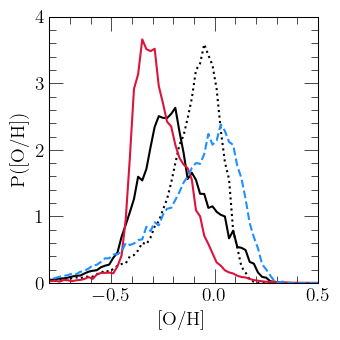

In [22]:
COLORS = ["black", "black", "crimson", "dodgerblue"]
LINESTYLES = [":", "-", "-", "--"]
MIN_RGAL = 7
MAX_RGAL = 9
MIN_ABSZ = 0
MAX_ABSZ = 0.5

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"[O/H]")
ax.set_ylabel(r"P([O/H])")
ax.set_xlim([-0.8, 0.5])
ax.set_ylim([0, 4])

def plot_mdf(ax, output, min_rgal, max_rgal, min_absz, max_absz, zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(min_rgal / zone_width)).filter(
        "zone_final", "<", int(max_rgal / zone_width)).filter(
        "absz", ">=", min_absz).filter(
        "absz", "<=", max_absz).filter(
        "mass", ">=", 1)
    dist, bins = np.histogram(stars["[o/h]"], range = [-1, 1], bins = 100, weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(xvals, dist, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i]
    }
    plot_mdf(ax, outputs[i], MIN_RGAL, MAX_RGAL, MIN_ABSZ, MAX_ABSZ, **kwargs)

plt.tight_layout()
plt.show()